### Bayesian Neural Networks from Dropout

Based on <a href="https://arxiv.org/abs/1506.02142">this</a> paper.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

/home/greg/virtual_environments/standard_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/greg/virtual_environments/standard_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/greg/virtual_environments/standard_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/greg/virtu

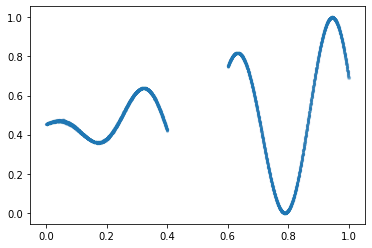

In [2]:
# Synthesise some data
n = 10000

X = np.linspace(0,200, n)/10
y = X*np.cos(X) + np.sin(X) * np.random.normal(0,0.1, n)

y = (y - np.min(y))/(np.max(y) - np.min(y))
X = (X - np.min(X))/(np.max(X) - np.min(X))

X = list(X)
y = list(y)

X_missing = X[:4000] + X[6000:]
y_missing = y[:4000] + y[6000:]

plt.scatter(X_missing, y_missing, s = 5, alpha = 0.1)

In [3]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return keras.layers.Dropout(p)(input_tensor, training=True)
    else:
        return keras.layers.Dropout(p)(input_tensor)

In [4]:
drop_rate = 0.5
mc = True
units = 1028

inputs = keras.layers.Input(shape=(1,))

output_1 = keras.layers.Dense(units, activation='relu')(inputs)
drop_1 = get_dropout(output_1, p=drop_rate, mc=mc)

output_2 = keras.layers.Dense(units//2, activation='relu')(drop_1)
drop_2 = get_dropout(output_2, p=drop_rate, mc=mc)

predictions = keras.layers.Dense(1)(drop_2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model = keras.Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mse')
model.fit(X_missing, y_missing, epochs = 10)  # starts training

Epoch 1/10
8000/8000 [==============================] - 1s 100us/sample - loss: 0.0095
Epoch 2/10
8000/8000 [==============================] - 1s 86us/sample - loss: 0.0092
Epoch 3/10
8000/8000 [==============================] - 1s 75us/sample - loss: 0.0083
Epoch 4/10
8000/8000 [==============================] - 1s 76us/sample - loss: 0.0085
Epoch 5/10
8000/8000 [==============================] - 1s 76us/sample - loss: 0.0074
Epoch 6/10
8000/8000 [==============================] - 1s 77us/sample - loss: 0.0076
Epoch 7/10
8000/8000 [==============================] - 1s 74us/sample - loss: 0.0077
Epoch 8/10
8000/8000 [==============================] - 1s 75us/sample - loss: 0.0074
Epoch 9/10
8000/8000 [==============================] - 1s 76us/sample - loss: 0.0076
Epoch 10/10
8000/8000 [==============================] - 1s 72us/sample - loss: 0.0073


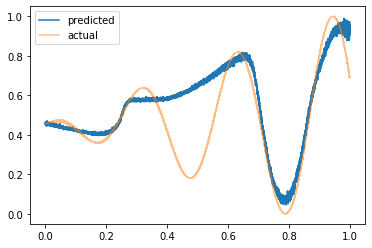

In [11]:
mc_preds = []
mc_samples = 50

X_test = np.linspace(0,2, 1000)

for i in range(mc_samples):
    
    mc_preds.append(model.predict(X))
    
mc_preds = np.array(mc_preds)

preds = np.mean(mc_preds, axis=0)

plt.plot(X[::99], preds[::99], label = "predicted")
plt.plot(X[::99], y[::99], alpha = 0.5, label = "actual")
plt.legend()

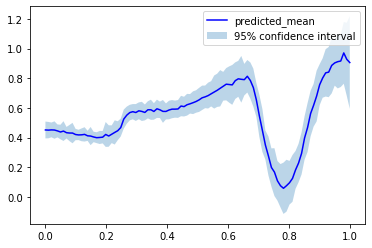

In [12]:
plt.plot(X[::99], preds[::99], label = "predicted_mean", c='b')

std = np.std(mc_preds, axis=0)

upper = preds + 1.97 * std
lower = preds - 1.97 * std

upper = np.reshape(upper, (-1))
lower = np.reshape(lower, (-1))

plt.fill_between(X[::99], lower[::99], upper[::99], interpolate = True, 
                 alpha = 0.3, label = "95% confidence interval")
plt.legend()

### Observations

 * Where data exists, the confidence intervals aren't very good since dropout doesn't seem to produce neural nets with very different predictions - even though there is a lot of noise.

 * The main benefit seems to be in quantifying uncertainty on predictions made with data that is outside the range of the training data.
 
 * Quantifying the uncertainty when making predictions within "holes" in the original data, ie areas which are surrounded by data, but themselves contain no data, is also hard for MC dropout. The neural nets tend to just connect adjacent points with a line, no matter how far apart those points are.

In [15]:
f = tf.keras.backend.function([model.inputs, tf.keras.backend.learning_phase()],
               [model.outputs])

In [18]:
f([X,1])

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: In[0] is not a matrix. Instead it has shape []
	 [[{{node dense/MatMul}}]]
	 [[dense_2/BiasAdd/_119]]
  (1) Invalid argument: In[0] is not a matrix. Instead it has shape []
	 [[{{node dense/MatMul}}]]
0 successful operations.
0 derived errors ignored.

In [22]:
model.predict(f, X, 32, 1)[0]

AttributeError: 'GraphExecutionFunction' object has no attribute 'shape'

In [ ]:
import numpy as np
from keras.callbacks import Callback
from keras import backend as K
from keras import models

class ModelTest(Callback):
    ''' Test model at the end of every X epochs.
    The model is tested using both MC dropout and the dropout
    approximation. Output metrics for various losses are supported.
    # Arguments
        Xt: model inputs to test.
        Yt: model outputs to get accuracy / error (ground truth).
        T: number of samples to use in MC dropout.
        test_every_X_epochs: test every test_every_X_epochs epochs.
        batch_size: number of data points to put in each batch
            (often larger than training batch size).
        verbose: verbosity mode, 0 or 1.
        loss: a string from ['binary', 'categorical', 'euclidean']
            used to calculate the testing metric.
        mean_y_train: mean of outputs in regression cases to add back
            to model output ('euclidean' loss).
        std_y_train: std of outputs in regression cases to add back
            to model output ('euclidean' loss).
    # References
        - [Dropout: A simple way to prevent neural networks from overfitting](http://jmlr.org/papers/v15/srivastava14a.html)
        - [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](http://arxiv.org/abs/1506.02142)
    '''
    def __init__(self, Xt, Yt, T=10, test_every_X_epochs=1, batch_size=500, verbose=1,
                 loss=None, mean_y_train=None, std_y_train=None):
        super(ModelTest, self).__init__()
        self.Xt = Xt
        self.Yt = np.array(Yt)
        self.T = T
        self.test_every_X_epochs = test_every_X_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.loss = loss
        self.mean_y_train = mean_y_train
        self.std_y_train = std_y_train
        self._predict_stochastic = None

    def predict_stochastic(self, X, batch_size=128, verbose=0):
        '''Generate output predictions for the input samples
        batch by batch, using stochastic forward passes. If
        dropout is used at training, during prediction network
        units will be dropped at random as well. This procedure
        can be used for MC dropout (see [ModelTest callbacks](callbacks.md)).
        # Arguments
            X: the input data, as a numpy array.
            batch_size: integer.
            verbose: verbosity mode, 0 or 1.
        # Returns
            A numpy array of predictions.
        # References
            - [Dropout: A simple way to prevent neural networks from overfitting](http://jmlr.org/papers/v15/srivastava14a.html)
            - [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](http://arxiv.org/abs/1506.02142)
        '''
        X = models.standardize_X(X)
        if self._predict_stochastic is None: # we only get self.model after init
        	self._predict_stochastic = K.function([self.model.X_test], [self.model.y_train])
        return self.model._predict_loop(self._predict_stochastic, X, batch_size, verbose)[0]


    def on_epoch_begin(self, epoch, logs={}):
        if epoch % self.test_every_X_epochs != 0:
            return
        model_output = self.model.predict(self.Xt, batch_size=self.batch_size,
                                          verbose=self.verbose)
        MC_model_output = []
        for _ in xrange(self.T):
            MC_model_output += [self.predict_stochastic(self.Xt,
                                                   batch_size=self.batch_size,
                                                   verbose=self.verbose)]
        MC_model_output = np.array(MC_model_output)
        MC_model_output_mean = np.mean(MC_model_output, 0)

        if self.loss == 'binary':
            standard_acc = np.mean(self.Yt == np.round(model_output.flatten()))
            MC_acc = np.mean(self.Yt == np.round(MC_model_output_mean.flatten()))
            print("Standard accuracy at epoch %05d: %0.5f" % (epoch, float(standard_acc)))
            print("MC accuracy at epoch %05d: %0.5f" % (epoch, float(MC_acc)))
        elif self.loss == 'categorical':
            standard_acc = np.mean(np.argmax(self.Yt, axis=-1) == np.argmax(model_output, axis=-1))
            MC_acc = np.mean(np.argmax(self.Yt, axis=-1) == np.argmax(MC_model_output_mean, axis=-1))
            print("Standard accuracy at epoch %05d: %0.5f" % (epoch, float(standard_acc)))
            print("MC accuracy at epoch %05d: %0.5f" % (epoch, float(MC_acc)))
        elif self.loss == 'euclidean':
            model_output = model_output * self.std_y_train + self.mean_y_train
            standard_err = np.mean((self.Yt - model_output)**2.0, 0)**0.5
            MC_model_output_mean = MC_model_output_mean * self.std_y_train + self.mean_y_train
            MC_err = np.mean((self.Yt - MC_model_output_mean)**2.0, 0)**0.5
            print("Standard error at epoch %05d: %0.5f" % (epoch, float(standard_err)))
            print("MC error at epoch %05d: %0.5f" % (epoch, float(MC_err)))
        else:
            raise Exception('No loss: ' + loss)